$S(x,t)$ is sampled at $M$ positions along the conveyor belt periodically for $N$ time intervals $\Delta t$   $S^n_m=S(x_m,t_n)$ 

The height of the sandpile at the beginning of the conveyor belt is $H_0(t)=0$  <em>(Dirichlet)</em>

The rate at which the sand falls of the end of the conveyor belt is proportional to the height of the sand pile? $\partial_x h(L,t)=\alpha h(L,t)$ <em>(Robin)</em>

$$
\begin{align}
AH^{n+1} &= b\quad \text{where}\quad b=H^n + S^n\Delta t \tag{1}\\
H_M^{n+1} &= (2\alpha \Delta x) H_{M-1}^{n+1} + H_{M-2}^{n+1}\\
H_0 &= 0 
\end{align}
$$

Assume that sand is dispensed at the beginning of the conveyor belt. 
Sand is poured into a funnel from another process from above, and falls through the funnel onto the beginning of the conveyor belt to be transported and subsequently processed.
Assume that the lower end of the funnel measures 15cm in diamter. 
$$
S(x,t) = 
\begin{cases}
0.02 & \text{if } 0<x\leq 0.15 \\
0  & \text{otherwise}
\end{cases}
$$


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse        import diags_array
from scipy.sparse.linalg import spsolve

In [20]:
L= 10.0 # 10m convyer belt, longest possible
v= 0.5 # advection velocity, mid point of suggested speeds
D= 0.008 # diffusion coefficient, small spreading of sand
alpha = 0 # Robin coefficient
s = 0.1 # source term, cont. rate of sand being added
s_start = 0
s_end = 0.15

Nx = 200; Nt = 50000
T = 40 # simulation length in seconds

x = np.linspace(0, L, Nx+1)
dx = x[1] - x[0] # grid spacing for finite differences

t = np.linspace(0, T, Nt+1)
dt = t[1] - t[0]

In [21]:
def plotting(U,x,t, exact_handle = None):
    # Set some markers and colours to make comparison easy
    markers = ['x','s','d','+','o','.']
    colours = ['xkcd:salmon','xkcd:golden rod','xkcd:teal','xkcd:purple','xkcd:slate','xkcd:silver']    
    
    # choose some (almost arbitrary) display times
    disp_times = [0, Nt//25, Nt//15, Nt//7, Nt//4, Nt//2]

    # Set up the figure
    fig, ax = plt.subplots(1, 1, figsize=(12, 5))

    if(exact_handle != None):
        for i, idx_t in enumerate(disp_times):
            label = 't = {0:.0e}'.format(t[idx_t]) if (0 < t[idx_t] < T) else 't = {0:.0f}'.format(t[idx_t])
            ax.plot(x, exact_handle(x,t[idx_t]), color = colours[i], label = label)

    for i, idx_t in enumerate(disp_times):
        label = 't = {0:.0e}'.format(t[idx_t]) if (0 < t[idx_t] < T) else 't = {0:.0f}'.format(t[idx_t])
        ax.plot(x[::2], U[idx_t][::2], linestyle = '', marker = markers[i], color = colours[i], label = label )

    ax.legend(ncols = 2, loc = 'center',  bbox_to_anchor=(1.2, 0.5))
    ax.set_xlim(0-1e-2,11.0+1e-2)    # zoom in on area of interest with a bit of leeway each end
    plt.xlabel("Space (x)")
    plt.ylabel("Solution")
    plt.show()

We solve the tridiagonal system in equation (1)

In [22]:
C = (D*dt)/(dx**2)
U = (v*dt)/dx

In [23]:
lower = -((2*C) + U) * np.ones(Nx+1)
main  = (1 + 2*C + U - C*((2*alpha*dx)/D)) * np.ones(Nx+1)
upper = -C * np.ones(Nx+1)
upper[0] = 0 # Dirichlet B.C. 0

A = diags_array([lower, main, upper], offsets=(-1, 0, 1), shape=(Nx+1, Nx+1), format='csr')

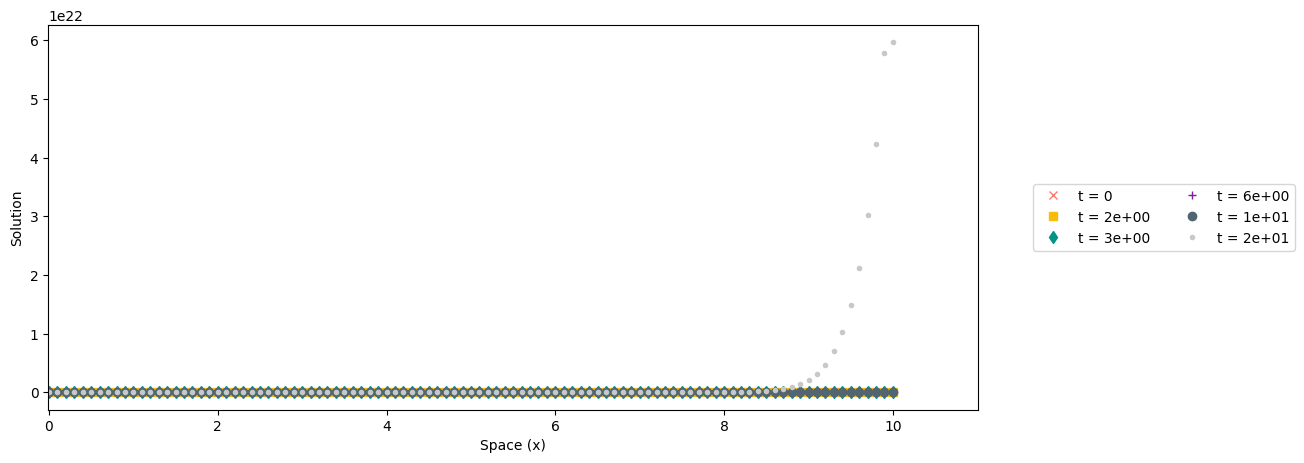

In [24]:
H = np.zeros((Nt+1,Nx+1))
S = np.zeros((Nt+1,Nx+1))

for i in range(Nx+1):
    delta = i*dx
    if(s_start <= delta and delta <= s_end):
        S[:,i] = s

for n in range(0, Nt):
    rhs = H[n] + S[n]*dt
    H[n+1] = spsolve(A, rhs)

plotting(H,x,t)